# Predicting Housing Prices using Ames Housing Dataset
### Kaylynn Mosier
### 15 Februrary 2025

Dataset can be accessed at the following link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

For this analysis, I used only the training set.

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from itertools import zip_longest
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

In [3]:
# Load dataset
housing_train = pd.read_csv("C:/Users/kayly/OneDrive/Desktop/MSDS/DSC680/Weeks 9-12/train.csv")
housing_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Understanding

The target varaible is SalePrice, contained in the training set. Gaining a good understanding of this variable is essential to building a good model.

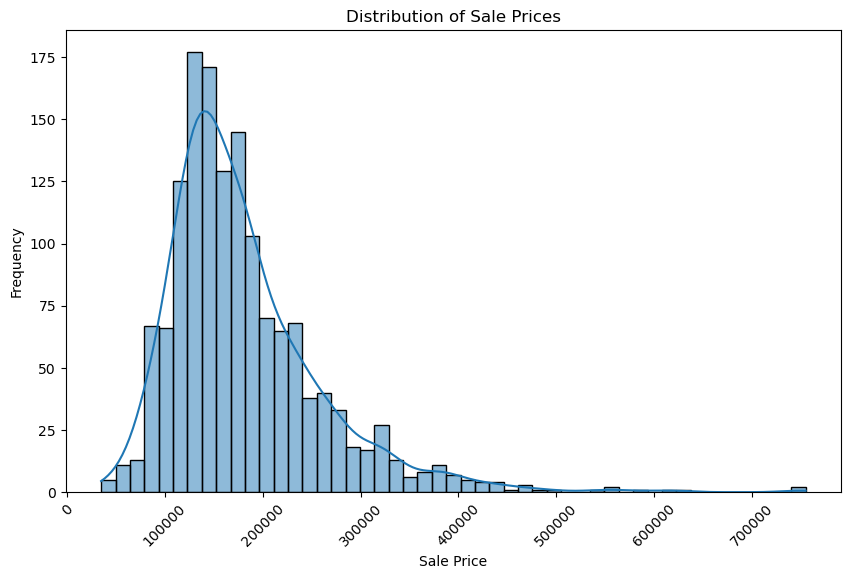

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(housing_train['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

The histogram shows a normal distribution for the target variable. However, there is a long tale to the right indicating there are likely outliers.

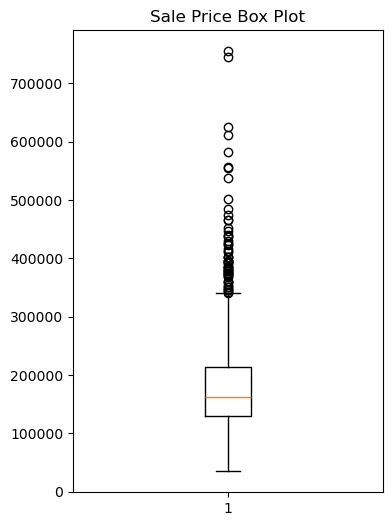

In [7]:
plt.figure(figsize=(4,6))
plt.boxplot(housing_train['SalePrice'])
plt.title('Sale Price Box Plot')
plt.show()

The boxplot confirms there are outliers in the target variable that need to be removed.

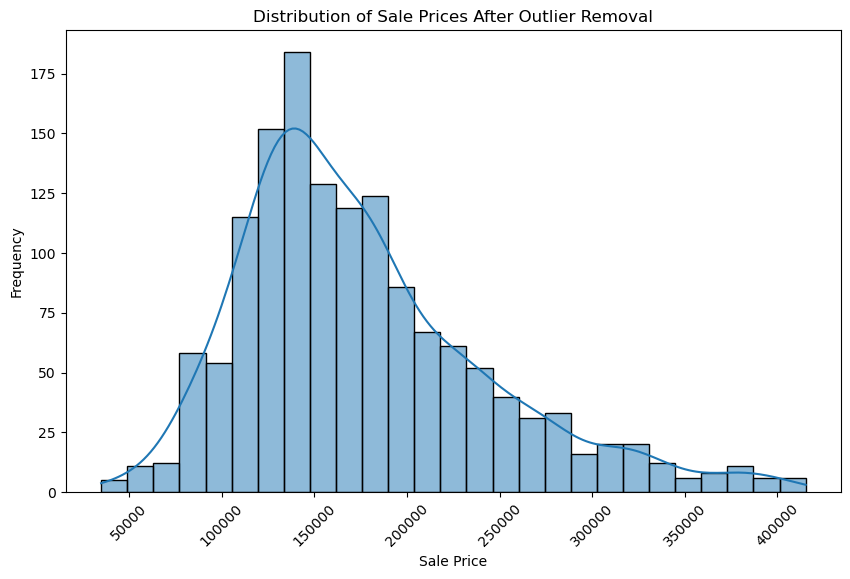

In [9]:
# Calculate Z-scores
z_scores = np.abs(stats.zscore(housing_train['SalePrice']))

# Define a threshold
threshold = 3

# Filter out outliers
housing_train = housing_train[(z_scores < threshold)]

plt.figure(figsize=(10,6))
sns.histplot(housing_train['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices After Outlier Removal')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Outliers wre removed using z-score, where any value with a z score greater than 3 was eliminated. All values above 450,000 were removed.

In [11]:
# Get descriptive statistics about target variable
housing_train['SalePrice'].describe()

count      1438.000000
mean     175844.522253
std       67475.861228
min       34900.000000
25%      129500.000000
50%      161500.000000
75%      210000.000000
max      415298.000000
Name: SalePrice, dtype: float64

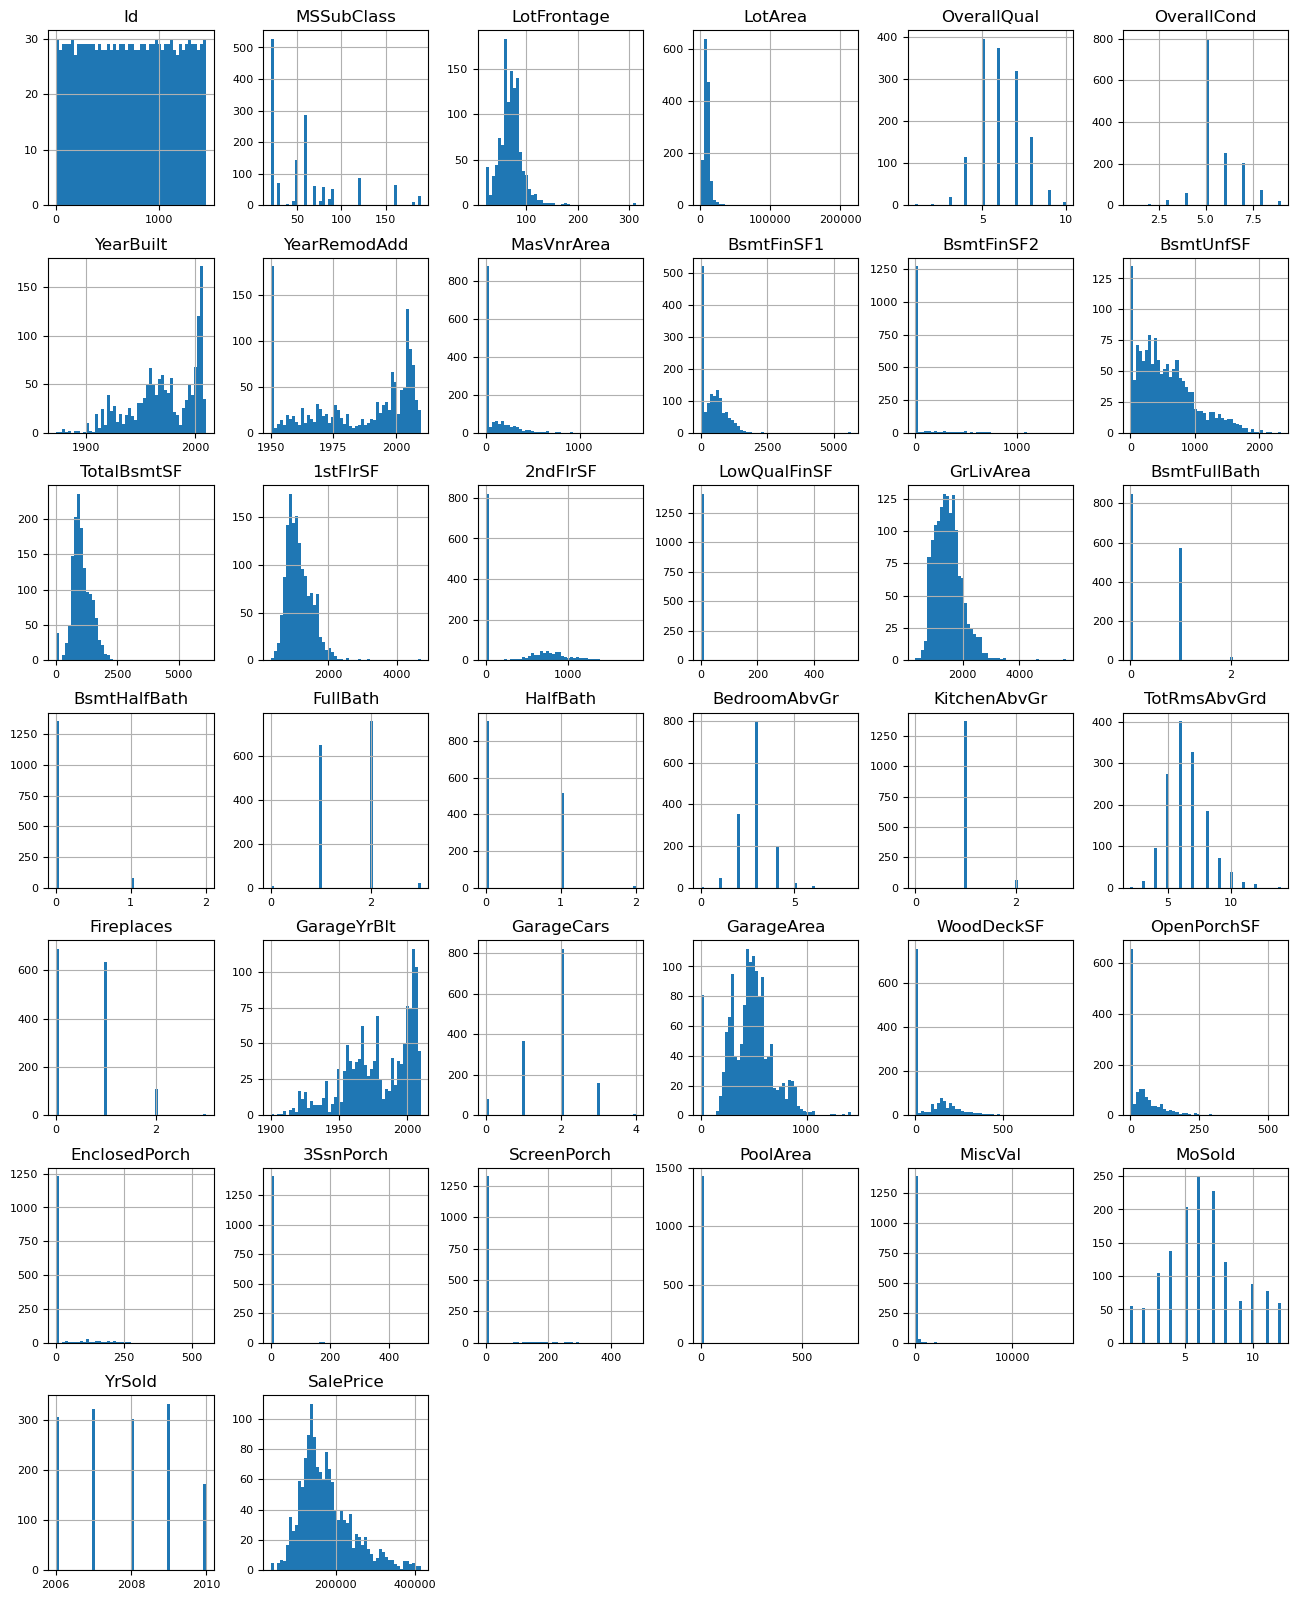

In [12]:
# Separate numeric features from training dataset
df_num = housing_train.select_dtypes(include = ['float64', 'int64'])

# Plot distributions of numerical features
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

There are numerous features that appear to have a lot of observations on '0'. These will likely need to be removed as they are not adding anything to model effectiveness if all ovservations are the same.

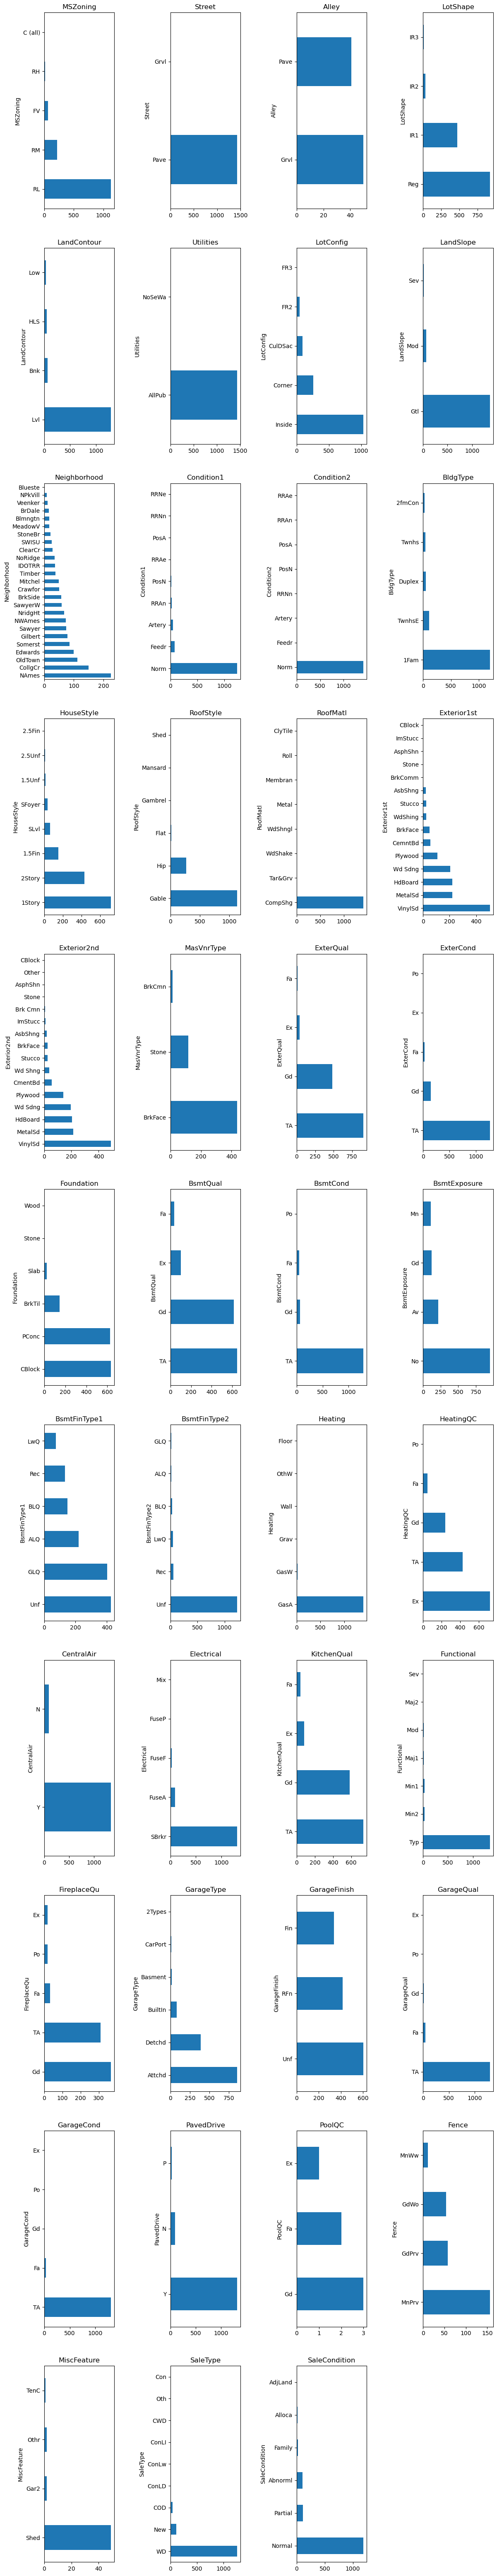

In [14]:
# separate categorical variables
df_cat = housing_train.select_dtypes(include = ['object'])

# Plot horizontal bar plot of each categorical variable
n_string_features = df_cat.shape[1]
nrows, ncols = ceil(n_string_features / 4), 4

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 80))

for feature_name, ax in zip_longest(df_cat, axs.ravel()):
    if feature_name is None:
        # do not show the axis
        ax.axis("off")
        continue

    df_cat[feature_name].value_counts().plot.barh(ax=ax)
    ax.set_title(feature_name)

plt.subplots_adjust(hspace=0.2, wspace=0.8)

Bar plot reveal colums street, utilities, condition2, roofmatl, heating all only have observances on one category. These do not add much to the story and will likely be removed during data prepartaion. 

# Data Preparation
The Id column does not add anything to analysis, so it can be dropped.

In [17]:
housing_train.drop('Id', axis=1, inplace=True)
print(housing_train.shape)

(1438, 80)


### Remvoing Low Correlatied Columns
Columns that have low/no correlation wtiht the target variable will not add to the power of the predictive model. In fact, they will likely introduct noise and reduce the accuracy of the model. These columns should be removed.

In [19]:
correlation = housing_train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).round(2)
correlation

SalePrice        1.00
OverallQual      0.80
GrLivArea        0.67
GarageCars       0.65
GarageArea       0.63
TotalBsmtSF      0.58
1stFlrSF         0.57
YearBuilt        0.56
FullBath         0.55
YearRemodAdd     0.54
GarageYrBlt      0.51
TotRmsAbvGrd     0.49
Fireplaces       0.47
MasVnrArea       0.42
LotFrontage      0.34
BsmtFinSF1       0.34
WoodDeckSF       0.33
OpenPorchSF      0.31
2ndFlrSF         0.29
HalfBath         0.28
LotArea          0.25
BsmtFullBath     0.23
BsmtUnfSF        0.22
BedroomAbvGr     0.17
ScreenPorch      0.09
MoSold           0.08
3SsnPorch        0.06
PoolArea         0.04
BsmtFinSF2      -0.00
MiscVal         -0.02
YrSold          -0.02
BsmtHalfBath    -0.03
LowQualFinSF    -0.06
OverallCond     -0.07
MSSubClass      -0.08
EnclosedPorch   -0.14
KitchenAbvGr    -0.15
Name: SalePrice, dtype: float64

In [20]:
low_correlation_columns = ['BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch', 'MoSold', '3SsnPorch', 'PoolArea', 'MiscVal',
                           'YrSold', 'BsmtHalfBath', 'LowQualFinSF', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']

In [21]:
print('Number of columns before dropping low correlation columns: ', housing_train.shape[1])

# Drop columns with low correlation
for column in low_correlation_columns:
    housing_train.drop(column, inplace=True, axis=1)

print('Number of columns after dropping low correlation columns: ', housing_train.shape[1])

Number of columns before dropping low correlation columns:  80
Number of columns after dropping low correlation columns:  65


### Handling Missing Values

In [23]:
# Count NA values in train dataset
print('---Column Name, Number of NA Values---')
for column in housing_train:
    if housing_train[column].isna().sum() > 0:
        print(column, '/', housing_train[column].isna().sum())

---Column Name, Number of NA Values---
LotFrontage / 257
Alley / 1347
MasVnrType / 867
MasVnrArea / 7
BsmtQual / 37
BsmtCond / 37
BsmtExposure / 38
BsmtFinType1 / 37
BsmtFinType2 / 38
Electrical / 1
FireplaceQu / 690
GarageType / 81
GarageYrBlt / 81
GarageFinish / 81
GarageQual / 81
GarageCond / 81
PoolQC / 1432
Fence / 1159
MiscFeature / 1384


Some columns have a significant number of NA values. All columns with greater than 80% of values as NA will be dropped.

In [25]:
print('Number of columns before dropping ones with high NA: ', housing_train.shape[1])

# Set threshold value at 80% of the number of rows in dataframe
threshold = int(housing_train.shape[0]) * 0.80
housing_train = housing_train.dropna(axis=1, thresh=threshold)

print('Number of columns before after ones with high NA: ',housing_train.shape[1])

Number of columns before dropping ones with high NA:  65
Number of columns before after ones with high NA:  59


## Scaling Numeric Column
Before data manipulation, this dataset contained both numerica and categorical columns. All columns that were originally categorical have been recoded into numeric columns. If that column had 5 possible categories, values for that column now lie between 0.0-4.0. Numeric columns could have a very large range. In the model building stage, the numeric column could end up being considered as 'more important' to the model simply because the range and maximum values are higher. To fix this, a standard scaler needs to be applied to these values to reduce the range to somethine more similiar to categorically recoded columns.

In [27]:
# Append all numeric columns to list
numeric_columns_train = []
for column in housing_train:
    if housing_train[column].dtype == 'float64':
        numeric_columns_train.append(column)
    if housing_train[column].dtype == 'int64':
        numeric_columns_train.append(column)

# Remove target variable from list
numeric_columns_train.remove('SalePrice')
numeric_columns_train

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

In [28]:
print('---- Column Name ---- Mean ---- Standard Deviation ----')
for column in numeric_columns_train:
    print(column, housing_train[column].mean(), np.std(housing_train[column]))

---- Column Name ---- Mean ---- Standard Deviation ----
LotFrontage 69.70533446232007 24.085324203595036
LotArea 10401.33866481224 9941.883193679476
OverallQual 6.051460361613352 1.3337889636190328
YearBuilt 1970.844923504868 30.082575482569993
YearRemodAdd 1984.5709318497914 20.645195721133806
MasVnrArea 97.82669461914745 168.99403729214208
BsmtFinSF1 432.394297635605 442.5252445854807
BsmtFinSF2 46.88664812239221 161.87510966513318
TotalBsmtSF 1042.757997218359 420.7511362137914
1stFlrSF 1149.6196105702365 370.8658655275223
2ndFlrSF 339.69054242002784 426.5129963855695
GrLivArea 1494.846314325452 495.11957437721884
FullBath 1.5521557719054242 0.540172226377459
HalfBath 0.3769123783031989 0.5015369222647108
TotRmsAbvGrd 6.465229485396383 1.570273550194603
Fireplaces 0.6015299026425591 0.639821686202527
GarageYrBlt 1978.0972733971996 24.658002088460435
GarageCars 1.7489568845618915 0.7376113740787038
GarageArea 467.32753824756605 209.6071773498757
WoodDeckSF 92.84631432545201 124.52257

In [29]:
# Apply scaler to numeric columns
scaler = StandardScaler()
housing_train[numeric_columns_train] = scaler.fit_transform(housing_train[numeric_columns_train])

In [30]:
# Confirm mean and stdev were corrected
print('---- Column Name ---- Mean ---- Standard Deviation ----')
for column in numeric_columns_train:
    print(column, housing_train[column].mean(), np.std(housing_train[column]))

---- Column Name ---- Mean ---- Standard Deviation ----
LotFrontage 1.80493497652862e-17 1.0
LotArea -3.458831119833589e-17 0.9999999999999981
OverallQual -2.643535213015672e-16 0.9999999999999952
YearBuilt -6.868250366526699e-16 1.0000000000000009
YearRemodAdd 1.3217676065078359e-15 1.0000000000000033
MasVnrArea 1.9861432166599585e-17 1.000000000000009
BsmtFinSF1 -1.2352968285119962e-17 0.9999999999999969
BsmtFinSF2 -1.9764749256191937e-17 0.9999999999999877
TotalBsmtSF -2.1000046084703935e-16 1.0000000000000002
1stFlrSF -2.8226532531499113e-16 1.0
2ndFlrSF -2.223534291321593e-17 0.9999999999999917
GrLivArea -1.976474925619194e-16 1.0000000000000013
FullBath -2.4705936570239924e-17 0.9999999999999937
HalfBath -1.1117671456607965e-17 1.0000000000000049
TotRmsAbvGrd 2.594123339875192e-16 1.0000000000000087
Fireplaces 4.941187314047985e-17 1.0000000000000147
GarageYrBlt 3.663981424820413e-15 0.9999999999999989
GarageCars 8.894137165286372e-17 0.9999999999999916
GarageArea 4.6941279483455

In [31]:
housing_train.head(5)

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice
0,RL,-0.195361,-0.196275,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0.340346,0.384875,TA,TA,Y,-0.745618,0.234003,WD,Normal,208500
1,RL,0.427425,-0.080602,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0.340346,-0.034958,TA,TA,Y,1.647522,-0.697275,WD,Normal,181500
2,RL,-0.070804,0.085362,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0.340346,0.671124,TA,TA,Y,-0.745618,-0.056067,WD,Normal,223500
3,RL,-0.402956,-0.085632,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,1.696074,0.833332,TA,TA,Y,-0.745618,-0.162935,WD,Abnorml,140000
4,RL,0.593501,0.388122,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,1.696074,1.758873,TA,TA,Y,0.796271,0.585141,WD,Normal,250000


## Ordinal Encoding of Categorical Variables

In each datset, some of the columns with missing values are categorical. According to the documentation, some of these columns are ordinal. NAs in these columns mean the house does not have this feature. Removing these columns would remove valuable information. Instead, the columns need to be transformed using ordinal encoding. Then, if missing values still remain they can be dealt with.

In [33]:
# Recode NaN as NA in datatable
housing_train = housing_train.fillna('NA')

In [34]:
# Encode columns using OrdinalEncoder from training set
columns_same_ordinality = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC', 'KitchenQual','GarageQual', 'GarageCond']
for column in columns_same_ordinality:
    encoder = OrdinalEncoder(categories=[['NA','Po', 'Fa', 'TA','Gd','Ex']])
    housing_train[column] = encoder.fit_transform(housing_train[[column]])

In [35]:
# Encode columns using OrdinalEncoder from training set
encoder = OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']])
housing_train['LandSlope'] = encoder.fit_transform(housing_train[['LandSlope']])

encoder = OrdinalEncoder(categories=[['NA', 'No', 'Mn','Av','Gd']])
housing_train['BsmtExposure'] = encoder.fit_transform(housing_train[['BsmtExposure']])

encoder = OrdinalEncoder(categories=[['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
housing_train['BsmtFinType1'] = encoder.fit_transform(housing_train[['BsmtFinType1']])

encoder = OrdinalEncoder(categories=[['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
housing_train['BsmtFinType2'] = encoder.fit_transform(housing_train[['BsmtFinType2']])

encoder = OrdinalEncoder(categories=[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']])
housing_train['Functional'] = encoder.fit_transform(housing_train[['Functional']])

encoder = OrdinalEncoder(categories=[['NA', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types']])
housing_train['GarageType'] = encoder.fit_transform(housing_train[['GarageType']])

encoder = OrdinalEncoder(categories=[['NA', 'Unf', 'RFn', 'Fin']])
housing_train['GarageFinish'] = encoder.fit_transform(housing_train[['GarageFinish']])

In [36]:
# Check number of columns
print('Training Set: ',len(housing_train.columns))

Training Set:  59


## Handling Missing Values
There are still a large number of missing values in each dataset. Since NAs from ordinal columns have been recoded, these are likely from numerical columns. I will fill missing values in numerical columns with the median of that column.

In [38]:
# Replace 'NA' with np.nan
housing_train = housing_train.where(housing_train != 'NA', np.nan)

# Check total number of NAs in each dataset
total_nans = housing_train.isna().sum().sum()
print(f"Total NaNs in Training Set: {total_nans}")

Total NaNs in Training Set: 346


In [39]:
# Find numerical columns with missing values and append to list
training_columns = housing_train.columns
missing_values = []
for column in training_columns:
    if housing_train[column].dtype != 'object':
        if housing_train[column].isna().sum() > 0:
            missing_values.append(column)

# Fill numerical columns with missing values with median of column
for column in missing_values:
    housing_train[column] = housing_train[column].fillna(housing_train[column].median())

# Print columns that still have missing values
training_columns = housing_train.columns
for column in training_columns:
        if housing_train[column].isna().sum() > 0:
            print(column, housing_train[column].isna().sum())

LotFrontage 257
MasVnrArea 7
Electrical 1
GarageYrBlt 81


LotFrontage is actually a numeric column that is incorrectly coded as an object. I can convert this column to the correct dtype and fill missing values with median like above.

In [41]:
housing_train['LotFrontage'].isna().sum()

257

In [42]:
# Change LotFrontage to float dtype
housing_train['LotFrontage'] = housing_train['LotFrontage'].astype('float64')
housing_train['LotFrontage'].dtype

dtype('float64')

In [43]:
# Fill NA with median of column
housing_train['LotFrontage'] = housing_train['LotFrontage'].fillna(housing_train['LotFrontage'].median())
housing_train['LotFrontage'].isna().sum()

0

In [44]:
# Drop final row with missing values
housing_train.dropna(how='any', inplace=True)

# Check if any NA values remain
housing_train.isna().sum().any()

False

In [45]:
print('Shape of Dataset: ', housing_train.shape)

Shape of Dataset:  (1349, 59)


## Encode Remaining Categorical Columns
The remaining categorical columns do not have ordinality, so I will encode them as numeric using OneHotEncoder from sklearn.

In [47]:
housing_train

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice
0,RL,-0.195361,-0.196275,Pave,Reg,Lvl,AllPub,Inside,0.0,CollgCr,...,0.340346,0.384875,3.0,3.0,Y,-0.745618,0.234003,WD,Normal,208500
1,RL,0.427425,-0.080602,Pave,Reg,Lvl,AllPub,FR2,0.0,Veenker,...,0.340346,-0.034958,3.0,3.0,Y,1.647522,-0.697275,WD,Normal,181500
2,RL,-0.070804,0.085362,Pave,IR1,Lvl,AllPub,Inside,0.0,CollgCr,...,0.340346,0.671124,3.0,3.0,Y,-0.745618,-0.056067,WD,Normal,223500
3,RL,-0.402956,-0.085632,Pave,IR1,Lvl,AllPub,Corner,0.0,Crawfor,...,1.696074,0.833332,3.0,3.0,Y,-0.745618,-0.162935,WD,Abnorml,140000
4,RL,0.593501,0.388122,Pave,IR1,Lvl,AllPub,FR2,0.0,NoRidge,...,1.696074,1.758873,3.0,3.0,Y,0.796271,0.585141,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,-0.319918,-0.249886,Pave,Reg,Lvl,AllPub,Inside,0.0,Gilbert,...,0.340346,-0.034958,3.0,3.0,Y,-0.745618,-0.086601,WD,Normal,175000
1456,RL,0.635020,0.278988,Pave,Reg,Lvl,AllPub,Inside,0.0,NWAmes,...,0.340346,0.155875,3.0,3.0,Y,2.057086,-0.697275,WD,Normal,210000
1457,RL,-0.153842,-0.136728,Pave,Reg,Lvl,AllPub,Inside,0.0,Crawfor,...,-1.015381,-1.027291,3.0,3.0,Y,-0.745618,0.218736,WD,Normal,266500
1458,RL,-0.070804,-0.068834,Pave,Reg,Lvl,AllPub,Inside,0.0,NAmes,...,-1.015381,-1.084541,3.0,3.0,Y,2.193608,-0.697275,WD,Normal,142125


In [48]:
# Get a list of categorical columns
categorical_columns = housing_train.select_dtypes(include=['object']).columns.tolist()

# Encode caegorical columns in a new dataframe, join new dataframe to old, and drop original columns
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(housing_train[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
training_encoded = pd.concat([housing_train, one_hot_df], axis=1)
training_encoded = training_encoded.drop(categorical_columns, axis=1)

# Drop rows that are still missing values
training_encoded.dropna(how='any', inplace=True)
training_encoded

,LotFrontage,LotArea,LandSlope,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.195361,-0.196275,0.0,0.711162,1.068894,0.892656,4.0,3.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.427425,-0.080602,0.0,-0.038582,0.171364,-0.415154,3.0,3.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.070804,0.085362,0.0,0.711162,1.002410,0.844219,4.0,3.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.402956,-0.085632,0.0,0.711162,-1.856388,-0.705778,3.0,3.0,3.0,4.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.593501,0.388122,0.0,1.460906,0.969168,0.747344,4.0,3.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0.635020,0.070576,0.0,0.711162,1.168619,1.037969,4.0,3.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1345,-0.818147,-0.442707,0.0,-1.538070,-1.690179,-1.674527,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1346,-0.029285,1.044034,0.0,0.711162,-0.094570,0.892656,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1347,0.967173,0.493333,0.0,1.460906,1.168619,1.086406,4.0,3.0,5.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


At this point, all features are prepared for model building.

# Model Building
I will try linear regression, Decision Tree Regression, Random Forest Regression, Gradient Boosting Regressor and evaluate these models using RMSE and R2. I will also plot the predicted values versus actual values to understand how if overfitting might be occuring.

RMSE is a measure of the difference in predicted values from actual values. A lower RMSE indicates a model predicts true values more accurately than a model with a higher RMSE.

R2 measures the amount of variation in target variable, in this case SalePrice, that is accounted for by the features. A value of 1.0 indicates a features perfectly account for all variation within the target. Values closer to 1.0 indicate better a better model than values closer to 0.

In [51]:
# Split into target and features
y = training_encoded['SalePrice'] # separate SalePrice as target varaible

X = training_encoded.copy(deep=True) # Copy training_encoded to gain features
print('Shape before droping target', X.shape)
X.drop('SalePrice', axis=1, inplace=True) # Drop target variable from dataset
print('Shape after dropping target', X.shape)

Shape before droping target (1245, 608)
Shape after dropping target (1245, 607)


In [52]:
# Split into train and test sets with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 127)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(996, 607) (996,)
(249, 607) (249,)


### Linear Regression

In [54]:
linear_regression = LinearRegression()
linear_model = linear_regression.fit(X_train, y_train)
linear_predict = linear_model.predict(X_test)

In [55]:
print('RMSE: ', root_mean_squared_error(y_test, linear_predict))
print('R2: ', r2_score(y_test, linear_predict))

RMSE:  2391204052514976.5
R2:  -1.5362709016955883e+21


This models RMSE is too high and R2 is much to far from 1 to even consider it as an option.

### Random Forest Regression

In [58]:
random_forest = RandomForestRegressor()
random_forest_model = random_forest.fit(X_train, y_train)
random_forest_predict = random_forest_model.predict(X_test)

In [59]:
print('RMSE: ', root_mean_squared_error(y_test, random_forest_predict))
print('R2: ', r2_score(y_test, random_forest_predict))

RMSE:  21027.88771991019
R2:  0.8811974322499943


RMSE is much lower than linear regression and R2 is close to one. This is a good model option.

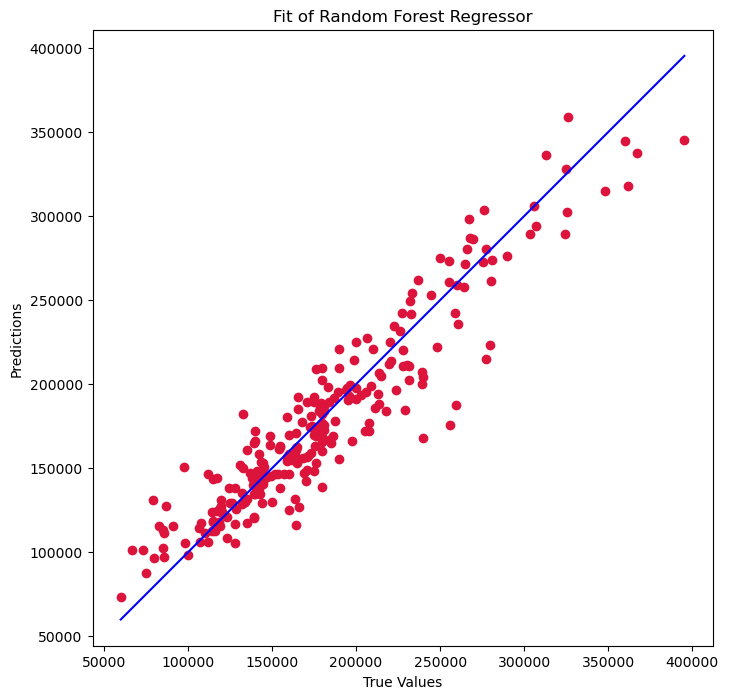

In [61]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, random_forest_predict, c='crimson')

p1 = max(max(random_forest_predict), max(y_test))
p2 = min(min(random_forest_predict), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('Fit of Random Forest Regressor')
plt.show()

This model fits fairly well at lower SalePrice. As sale price increases though, the accuracy of this model is greatly decreased.

### Decision Tree Regression

In [64]:
decision_tree = DecisionTreeRegressor()
decision_tree_model = decision_tree.fit(X_train, y_train)
decision_tree_predict = decision_tree_model.predict(X_test)

In [65]:
print('RMSE: ', root_mean_squared_error(y_test, decision_tree_predict))
print('R2: ', r2_score(y_test, decision_tree_predict))

RMSE:  34334.336573052446
R2:  0.6832680687461727


The RMSE is higher and R2 is lower than the previous model. This is likely not a good fit.

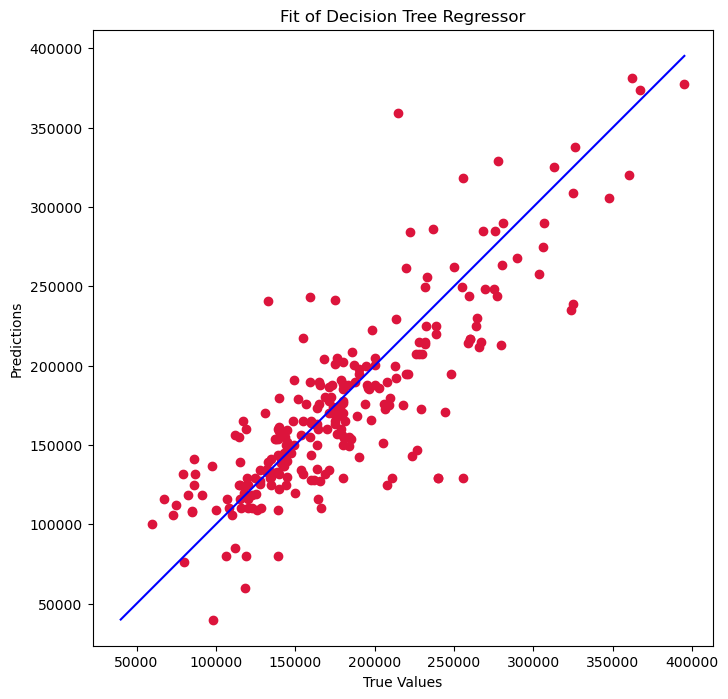

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, decision_tree_predict, c='crimson')

p1 = max(max(decision_tree_predict), max(y_test))
p2 = min(min(decision_tree_predict), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Fit of Decision Tree Regressor')
plt.axis('equal')
plt.show()

This model has a worse fit than the previous. Predicted values are more spread out througout the range of sale prices.

### Gradient Boosting Regressor

In [70]:
gradient_boost = GradientBoostingRegressor()
gradient_boost_model = gradient_boost.fit(X_train, y_train)
gradient_boost_predict = gradient_boost_model.predict(X_test)

In [71]:
print('RMSE: ', root_mean_squared_error(y_test, gradient_boost_predict))
print('R2: ', r2_score(y_test, gradient_boost_predict))

RMSE:  19939.04115539369
R2:  0.8931823379615667


The RMSE is much lower than other models and R2 is closer to 1. This is the preferred model.

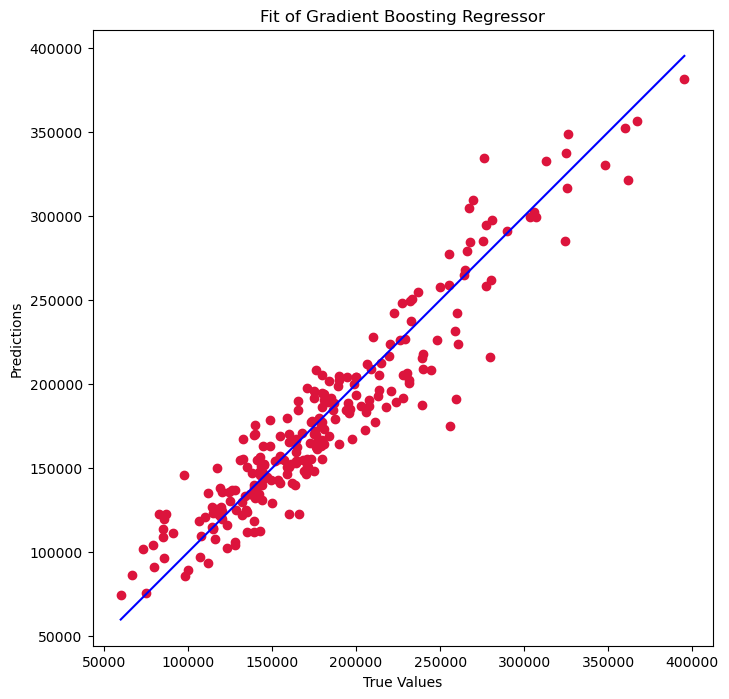

In [73]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, gradient_boost_predict, c='crimson')

p1 = max(max(gradient_boost_predict), max(y_test))
p2 = min(min(gradient_boost_predict), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Fit of Gradient Boosting Regressor')
plt.axis('equal')
plt.show()

Of all the models tested, this has the best fit of predicted values. 

## Hyperparameter Tuning

In [76]:
# Build hyperparameter grid for GradientBoostingRegressor
param_grid = {
'n_estimators': [25, 50, 100],
'subsample' : [0.25, 0.50, 0.75, 1.0],
'criterion' :['friedman_mse', 'squared_error'],
'max_depth': [6, 9, 12, 15]
}

# Run random search to find best hyperparameters from parameter grid
random_search_gradient = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_grid)
random_search_gradient.fit(X_train, y_train)
print(random_search_gradient.best_params_)

{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 12, 'criterion': 'squared_error'}


In [77]:
# Initiate best model
best_gradient_boost_model = GradientBoostingRegressor(max_depth=15, n_estimators=50, subsample=0.5, criterion='squared_error')

# Fit best model
best_gradient_boost_model = best_gradient_boost_model.fit(X_train, y_train)

# Make predictions with model
predictions_best_gradient_boost = best_gradient_boost_model.predict(X_test)

# Check accuracy
print('RMSE: ', root_mean_squared_error(y_test, predictions_best_gradient_boost))
print('R2: ', r2_score(y_test, predictions_best_gradient_boost)) 

RMSE:  19728.68486871866
R2:  0.895424295223268


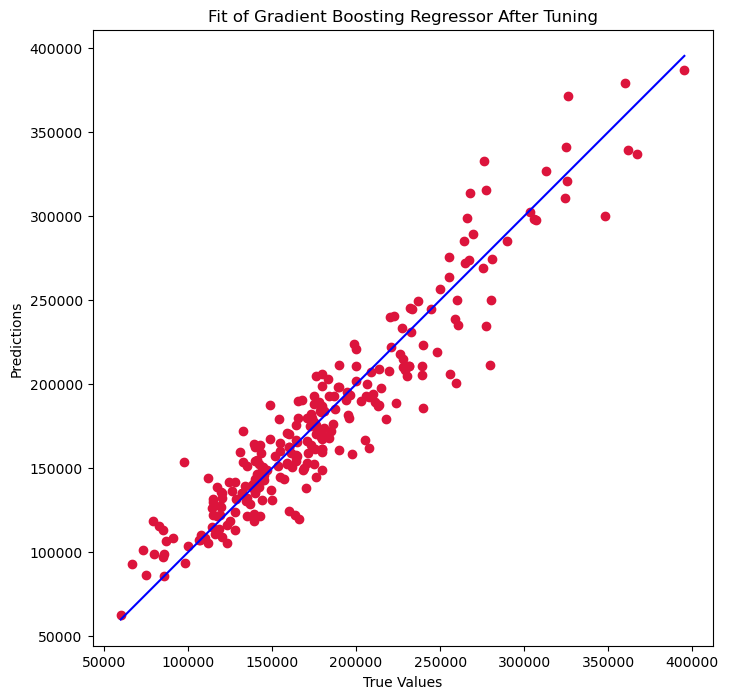

In [78]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, predictions_best_gradient_boost, c='crimson')

p1 = max(max(predictions_best_gradient_boost), max(y_test))
p2 = min(min(predictions_best_gradient_boost), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Fit of Gradient Boosting Regressor After Tuning')
plt.axis('equal')
plt.show()

This final model is an improvement on the non-tuned gradient boosting regressor and is the preferred model to predict SalePrcie in this dataset.